# Домашнее задание

### Урок 2. Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)

In [1]:
import pandas as pd

Наши новости

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [4]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [5]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [6]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [7]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [8]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [9]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-8-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 32.5 s


In [10]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 2min 57s


А теперь в 3 строчки обучим нашу модель

In [11]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, год, тропический, углеродный, цикл...
26999    [жить, примерно, тыс, год, назад, территория, ...
Name: title, Length: 27000, dtype: object

In [12]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [13]:
common_dictionary[10]

'ватутин'

In [14]:
common_corpus

[[(0, 5),
  (1, 2),
  (2, 1),
  (3, 2),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 4),
  (17, 1),
  (18, 1),
  (19, 4),
  (20, 1),
  (21, 1),
  (22, 3),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 2),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 2),
  (46, 1),
  (47, 2),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 3),
  (59, 1),
  (60, 2),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 3),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 3),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 1),
  (89, 1),
  (90, 1),
  (91, 1)

Все просто - это словарь наших слов

Запускаем обучение

In [15]:
from gensim.models import LdaModel

In [16]:
LdaModel?

In [17]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 58.7 s


In [18]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [19]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(2, 0.33592364),
 (3, 0.07907694),
 (9, 0.029307533),
 (11, 0.036764946),
 (15, 0.44139558),
 (24, 0.060580935)]

In [20]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: автомобиль савченко леонтьев сердце пострадать крыша заболеть
topic_1: погибнуть восток фотография топливо бомба мальчик достигать
topic_2: газ век железный фаза макаров новгород сектор
topic_3: космос запустить физика польша польский задать критиковать
topic_4: университет объяснять корпус сон компьютерный страдать автобус
topic_5: остров северный год памятник южный космонавт поток
topic_6: год рост это который страна также миссия
topic_7: который год это правительство свой государство глава
topic_8: фонд исследование санкция рубль год россия ставка
topic_9: сша военный ракета год американский который запуск
topic_10: млрд бюджет расход звонок грант автономный достопримечательность
topic_11: ребёнок который человек это депутат закон квартира
topic_12: земля человек мужчина женщина тело nn дом
topic_13: пациент рейс белоруссия страдать планета белорусский группа
topic_14: nn гражданин россия министр ребёнок российский nnn
topic_15: это который человек год мочь свой мозг
topic_

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [21]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [22]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.012693,0.087727,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.098265,0.0,0.0,0.0,0.0,0.0,0.012724,0.0,0.072727
1,4896,0.0,0.000000,0.302746,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.674236,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
2,4897,0.0,0.000000,0.335848,0.079078,0.0,0.0,0.0,0.000000,0.0,...,0.441540,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.060269
3,4898,0.0,0.000000,0.176216,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.403982,0.153632,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
4,4899,0.0,0.000000,0.097117,0.000000,0.0,0.0,0.0,0.148025,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.574163


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [23]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [24]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [25]:
doc_dict[293622]

array([0.        , 0.        , 0.        , 0.        , 0.02461724,
       0.04698519, 0.        , 0.06725476, 0.        , 0.09630024,
       0.        , 0.18075931, 0.12192795, 0.        , 0.11028252,
       0.07364154, 0.16281925, 0.        , 0.        , 0.        ,
       0.0724262 , 0.        , 0.        , 0.        , 0.03447456])

In [26]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [27]:
get_user_embedding(user_articles_list)

array([0.        , 0.00408161, 0.        , 0.        , 0.        ,
       0.        , 0.01905698, 0.15580683, 0.01853999, 0.13875839,
       0.        , 0.08039538, 0.03537781, 0.01324269, 0.06192999,
       0.0287481 , 0.21478024, 0.01640193, 0.        , 0.00311533,
       0.05669709, 0.        , 0.00329111, 0.        , 0.1367832 ])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [28]:
#users['articles'].iloc[33]

In [29]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [30]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.00000,0.005402,0.00000,0.0,0.014414,0.04585,0.103096,0.091199,0.010607,...,0.058684,0.147798,0.002682,0.000000,0.007355,0.049427,0.000000,0.026165,0.000000,0.044664
1,u108690,0.00625,0.000000,0.00000,0.0,0.012720,0.00000,0.084653,0.167207,0.031550,...,0.149091,0.265578,0.002892,0.002357,0.000000,0.018442,0.001894,0.002862,0.000000,0.077112
2,u108339,0.00000,0.010404,0.00504,0.0,0.002146,0.00000,0.017431,0.129096,0.015694,...,0.065565,0.148680,0.011246,0.000000,0.000000,0.007966,0.000000,0.024327,0.003032,0.167294


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [31]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [32]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.00000,0.005402,0.00000,0.0,0.014414,0.04585,0.103096,0.091199,0.010607,...,0.147798,0.002682,0.000000,0.007355,0.049427,0.000000,0.026165,0.000000,0.044664,0
1,u108690,0.00625,0.000000,0.00000,0.0,0.012720,0.00000,0.084653,0.167207,0.031550,...,0.265578,0.002892,0.002357,0.000000,0.018442,0.001894,0.002862,0.000000,0.077112,1
2,u108339,0.00000,0.010404,0.00504,0.0,0.002146,0.00000,0.017431,0.129096,0.015694,...,0.148680,0.011246,0.000000,0.000000,0.007966,0.000000,0.024327,0.003032,0.167294,1


In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [34]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [35]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [36]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.04807902, 0.0787142 , 0.55713219, 0.20570088, 0.02695077,
       0.02982541, 0.12338927, 0.14652094, 0.19036572, 0.02642259])

In [37]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [38]:
import itertools

In [39]:
precision_mean, recall_mean, thresholds_mean = precision_recall_curve(y_test, preds)
fscore_mean = (2 * precision_mean * recall_mean) / (precision_mean + recall_mean)
ix_mean = np.argmax(fscore_mean)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_mean[ix_mean], 
                                                                        fscore_mean[ix_mean],
                                                                        precision_mean[ix_mean],
                                                                        recall_mean[ix_mean]))

Best Threshold=0.259931, F-Score=0.755, Precision=0.702, Recall=0.816


In [40]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1670   85]
 [  46  199]]


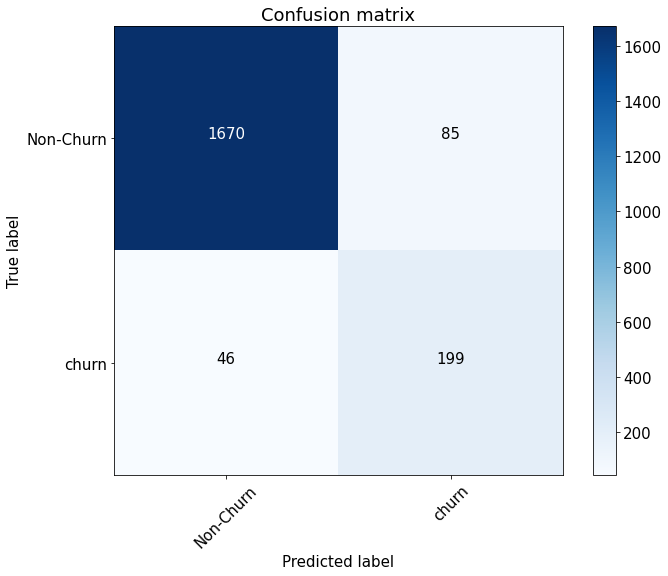

In [41]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds_mean[ix_mean])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [66]:
roc_auc_score_mean = roc_auc_score(y_test, preds)
roc_auc_score_mean

0.9837060294203152

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)

2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [43]:
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [44]:
get_user_embedding_median(user_articles_list)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.1305147 , 0.        , 0.17154544,
       0.        , 0.        , 0.        , 0.        , 0.06737152,
       0.01306514, 0.24835086, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.08191616])

In [45]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.0,0.0,0.0,0.006336,0.023493,0.107183,0.077734,0.000000,...,0.000000,0.122515,0.0,0.0,0.0,0.042506,0.0,0.019589,0.0,0.008170
1,u108690,0.0,0.0,0.0,0.0,0.000000,0.000000,0.063889,0.171388,0.018455,...,0.142093,0.291277,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.044892
2,u108339,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.114392,0.005812,...,0.054591,0.139799,0.0,0.0,0.0,0.000000,0.0,0.019773,0.0,0.189405


In [46]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.0,0.0,0.0,0.006336,0.023493,0.107183,0.077734,0.000000,...,0.122515,0.0,0.0,0.0,0.042506,0.0,0.019589,0.0,0.008170,0
1,u108690,0.0,0.0,0.0,0.0,0.000000,0.000000,0.063889,0.171388,0.018455,...,0.291277,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.044892,1
2,u108339,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.114392,0.005812,...,0.139799,0.0,0.0,0.0,0.000000,0.0,0.019773,0.0,0.189405,1


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [48]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [49]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.03443219, 0.00666277, 0.75707484, 0.1909365 , 0.02462542,
       0.01796675, 0.06549941, 0.10785585, 0.41739528, 0.03480616])

In [50]:
precision_median, recall_median, thresholds_median = precision_recall_curve(y_test, preds)
fscore_median = (2 * precision_median * recall_median) / (precision_median + recall_median)
ix_median = np.argmax(fscore_median)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_median[ix_median], 
                                                                        fscore_median[ix_median],
                                                                        precision_median[ix_median],
                                                                        recall_median[ix_median]))

Best Threshold=0.278716, F-Score=0.839, Precision=0.798, Recall=0.886


Confusion matrix, without normalization
[[1700   55]
 [  29  216]]


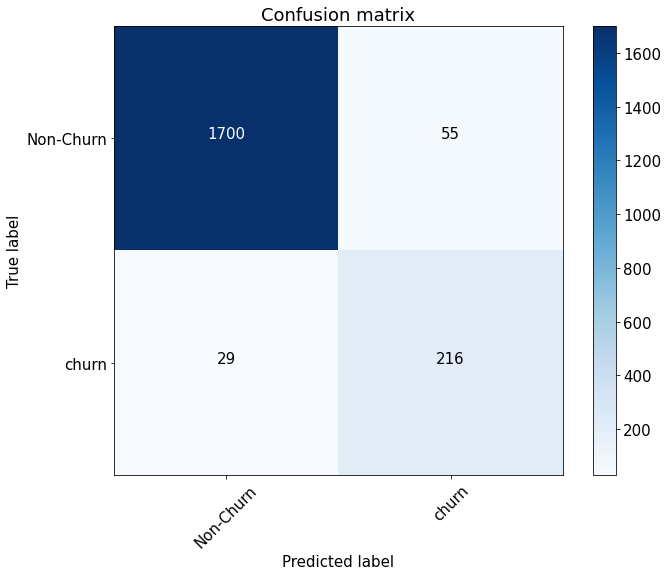

In [51]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds_median[ix_median])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [67]:
roc_auc_score_median = roc_auc_score(y_test, preds)
roc_auc_score_median

0.9837060294203152

3. Повторить п.2, но используя уже не медиану, а max

In [53]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [54]:
get_user_embedding_max(user_articles_list)

array([0.        , 0.02448967, 0.        , 0.        , 0.        ,
       0.        , 0.09263528, 0.38784528, 0.09574579, 0.25730172,
       0.        , 0.3439188 , 0.21226685, 0.07945615, 0.14008957,
       0.08162828, 0.51097798, 0.0984116 , 0.        , 0.01869198,
       0.30901042, 0.        , 0.01974666, 0.        , 0.46479821])

In [55]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.032412,0.000000,0.0,0.049198,0.158691,0.224575,0.270260,0.063644,...,0.278460,0.414552,0.016092,0.000000,0.044133,0.127486,0.000000,0.072457,0.000000,0.217169
1,u108690,0.037498,0.000000,0.000000,0.0,0.040616,0.000000,0.221593,0.287795,0.082615,...,0.279354,0.366076,0.017355,0.014141,0.000000,0.057404,0.011366,0.017172,0.000000,0.229049
2,u108339,0.000000,0.033795,0.030243,0.0,0.012877,0.000000,0.086285,0.317265,0.042258,...,0.136608,0.203917,0.041124,0.000000,0.000000,0.026352,0.000000,0.055140,0.018191,0.298155


In [56]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.032412,0.000000,0.0,0.049198,0.158691,0.224575,0.270260,0.063644,...,0.414552,0.016092,0.000000,0.044133,0.127486,0.000000,0.072457,0.000000,0.217169,0
1,u108690,0.037498,0.000000,0.000000,0.0,0.040616,0.000000,0.221593,0.287795,0.082615,...,0.366076,0.017355,0.014141,0.000000,0.057404,0.011366,0.017172,0.000000,0.229049,1
2,u108339,0.000000,0.033795,0.030243,0.0,0.012877,0.000000,0.086285,0.317265,0.042258,...,0.203917,0.041124,0.000000,0.000000,0.026352,0.000000,0.055140,0.018191,0.298155,1


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [58]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [59]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([2.77306956e-02, 6.18995290e-04, 8.99299188e-01, 1.97533142e-01,
       7.46240148e-03, 4.62980027e-04, 3.18062380e-02, 2.18995852e-01,
       2.08873513e-01, 9.88598707e-02])

In [60]:
precision_max, recall_max, thresholds_max = precision_recall_curve(y_test, preds)
fscore_max = (2 * precision_max * recall_max) / (precision_max + recall_max)
ix_max = np.argmax(fscore_max)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_max[ix_max], 
                                                                        fscore_max[ix_max],
                                                                        precision_max[ix_max],
                                                                        recall_max[ix_max]))

Best Threshold=0.343965, F-Score=0.845, Precision=0.812, Recall=0.882


Confusion matrix, without normalization
[[1705   50]
 [  30  215]]


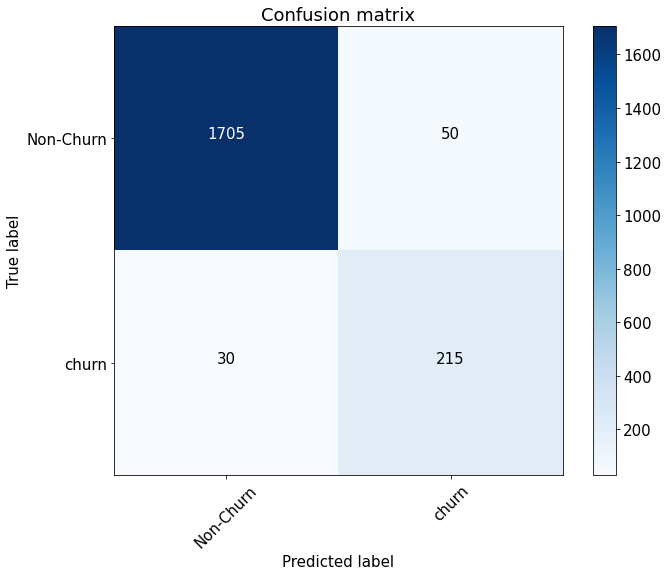

In [61]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds_max[ix_max])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [68]:
roc_auc_score_max = roc_auc_score(y_test, preds)
roc_auc_score_max

0.9837060294203152

4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.

5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [70]:
df = pd.DataFrame([['mean', roc_auc_score_mean, precision_mean[ix_mean], recall_mean[ix_mean], fscore_mean[ix_mean]], 
                   ['median', roc_auc_score_median, precision_median[ix_median], recall_median[ix_median], fscore_median[ix_median]], 
                   ['max', roc_auc_score_max, precision_max[ix_max], recall_max[ix_max], fscore_max[ix_max]]],
                  columns=['model', 'roc_auc', 'precision', 'recall', 'fscore'])
df

,model,roc_auc,precision,recall,fscore
0,mean,0.983706,0.701754,0.816327,0.754717
1,median,0.983706,0.797794,0.885714,0.839458
2,max,0.983706,0.812030,0.881633,0.845401


6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

Cамый эффективный способ - max, так как минимизируется разброс интересов пользователя.